Using xgboost or a random forest regressor to determine relevant features

In [1]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
data_freq = '4h'
day_periods = 6

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
in_sample_end_datetime = pd.to_datetime('2022-08-05 04:00:00')
# in_sample_end_datetime = pd.to_datetime('2023-12-31 20:00:00')

In [4]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [86]:
import numpy as np

def get_signals(price_volume_df):
    coin_signals_data = dict()
    #coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals_data["price-1"] = price_volume_df["close"].shift()
    coin_signals_data["price-2"] = price_volume_df["close"].shift(2)
    coin_signals_data["price-3"] = price_volume_df["close"].shift(3)
    coin_signals_data["log price-1"] = np.log(coin_signals_data["price-1"])
    coin_signals_data["log price-2"] = np.log(coin_signals_data["price-2"])
    coin_signals_data["log price-3"] = np.log(coin_signals_data["price-3"])
    coin_signals_data["price-1 - price-2"] = coin_signals_data["price-1"] - coin_signals_data["price-2"]
    coin_signals_data["price-2 - price-3"] = coin_signals_data["price-2"] - coin_signals_data["price-3"]
    coin_signals_data["price-1 - price-3"] = coin_signals_data["price-1"] - coin_signals_data["price-3"]
    coin_signals_data["price change rate 1-2"] = coin_signals_data["price-1"] / coin_signals_data["price-2"] - 1
    coin_signals_data["price change rate 2-3"] = coin_signals_data["price-2"] / coin_signals_data["price-3"] - 1
    coin_signals_data["log price quotient 1-2"] = np.log(coin_signals_data["price-1"] / coin_signals_data["price-2"])
    coin_signals_data["log price quotient 2-3"] = np.log(coin_signals_data["price-2"] / coin_signals_data["price-3"])

    coin_signals_data["volume-1"] = price_volume_df["volume"].shift()
    coin_signals_data["volume-1"].loc[coin_signals_data["volume-1"] == 0] = 0.001
    coin_signals_data["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals_data["volume-2"].loc[coin_signals_data["volume-2"] == 0] = 0.001
    coin_signals_data["volume-3"] = price_volume_df["volume"].shift(3)
    coin_signals_data["volume-3"].loc[coin_signals_data["volume-3"] == 0] = 0.001
    coin_signals_data["log volume-1"] = np.log(coin_signals_data["volume-1"])
    coin_signals_data["log volume-2"] = np.log(coin_signals_data["volume-2"])
    coin_signals_data["log volume-3"] = np.log(coin_signals_data["volume-3"])
    coin_signals_data["volume-1 - volume-2"] = coin_signals_data["volume-1"] - coin_signals_data["volume-2"]
    coin_signals_data["volume-2 - volume-3"] = coin_signals_data["volume-2"] - coin_signals_data["volume-3"]
    coin_signals_data["volume-1 - volume-3"] = coin_signals_data["volume-1"] - coin_signals_data["volume-3"]
    coin_signals_data["volume change rate 1-2"] = coin_signals_data["volume-1"] / coin_signals_data["volume-2"] - 1
    coin_signals_data["volume change rate 2-3"] = coin_signals_data["volume-2"] / coin_signals_data["volume-3"] - 1
    coin_signals_data["log volume quotient 1-2"] = np.log(coin_signals_data["volume-1"] / coin_signals_data["volume-2"])
    coin_signals_data["log volume quotient 2-3"] = np.log(coin_signals_data["volume-2"] / coin_signals_data["volume-3"])

    price_columns = [
        "price-1", "price-2", "price-3", "log price-1", "log price-2", "log price-3", "price-1 - price-2",
        "price-2 - price-3", "price-1 - price-3", "price change rate 1-2", "price change rate 2-3",
        "log price quotient 1-2", "log price quotient 2-3"]

    volume_columns = [
        "volume-1", "volume-2", "volume-3", "log volume-1", "log volume-2", "log volume-3",
        "volume-1 - volume-2", "volume-2 - volume-3", "volume-1 - volume-3", "volume change rate 1-2",
        "volume change rate 2-3", "log volume quotient 1-2", "log volume quotient 2-3"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals_data[p_col + " x " + v_col] = coin_signals_data[p_col] * coin_signals_data[v_col]
    
    return pd.DataFrame(coin_signals_data, index=price_volume_df.index)


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        price_volume_df = px_data[coin][["close", "volume"]].astype(float)
        #price_volume_df = px_data[coin][
        #    ["close", "quote_volume"]].rename({"quote_volume": "volume"}, axis=1).astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals

In [87]:
px_data['BTCUSDT']['close']

open_time
2020-01-01 00:00:00     7230.71000000
2020-01-01 04:00:00     7205.50000000
2020-01-01 08:00:00     7195.80000000
2020-01-01 12:00:00     7233.02000000
2020-01-01 16:00:00     7223.72000000
                            ...      
2025-03-09 16:00:00    82557.54000000
2025-03-09 20:00:00    80672.47000000
2025-03-10 00:00:00    81997.61000000
2025-03-10 04:00:00    82382.35000000
2025-03-10 08:00:00    82338.54000000
Name: close, Length: 11367, dtype: object

In [88]:
m = len(px_data['BTCUSDT'].index)
px_data['BTCUSDT'].index[int(m * 0.5)]


Timestamp('2022-08-06 00:00:00')

In [89]:
from sklearn.ensemble import RandomForestRegressor

coin_to_signals = get_signals_for_all_coins(px_data)
coin_to_rfr_model = dict()

for coin, signals in coin_to_signals.items():
    rfr_model = RandomForestRegressor(random_state=836, max_depth=5)
    
    in_sample_signals = signals.iloc[3:].loc[:in_sample_end_datetime]
    in_sample_close_price = px_data[coin]['close'].iloc[3:].loc[:in_sample_end_datetime]
    
    rfr_model.fit(in_sample_signals, in_sample_close_price)
    coin_to_rfr_model[coin] = rfr_model
    print(f"Model fitted for {coin}.")

Model fitted for BTCUSDT.
Model fitted for ETHUSDT.
Model fitted for ADAUSDT.
Model fitted for BNBUSDT.
Model fitted for XRPUSDT.
Model fitted for DOTUSDT.
Model fitted for MATICUSDT.


In [90]:
coin_to_rfr_model['BTCUSDT']

RandomForestRegressor(max_depth=5, random_state=836)

<Axes: xlabel='open_time'>

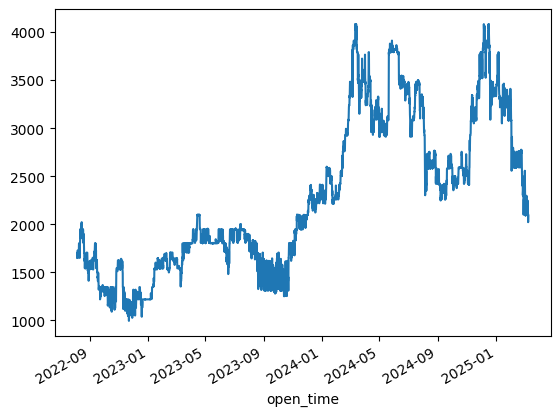

In [91]:
from datetime import timedelta

out_sample_start_datetime = in_sample_end_datetime + timedelta(hours=4)
eth_signals_out_sample = coin_to_signals['ETHUSDT'].loc[out_sample_start_datetime:]
eth_out_sample_predictions = coin_to_rfr_model['ETHUSDT'].predict(eth_signals_out_sample)
eth_out_sample_predictions = pd.Series(eth_out_sample_predictions, index=eth_signals_out_sample.index)

eth_out_sample_predictions.plot()

<Axes: xlabel='open_time'>

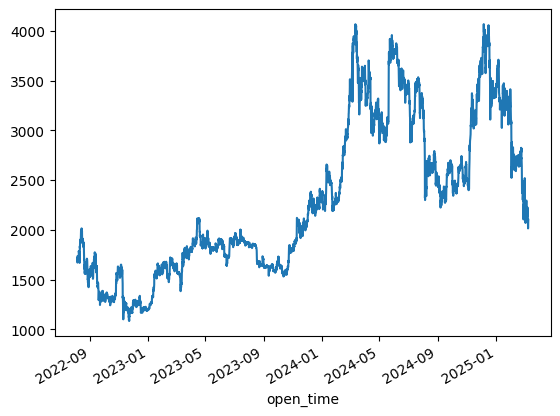

In [92]:
eth_price = px_data['ETHUSDT'].loc[out_sample_start_datetime:]['close'].astype(float)
eth_price.plot()

<Axes: xlabel='open_time'>

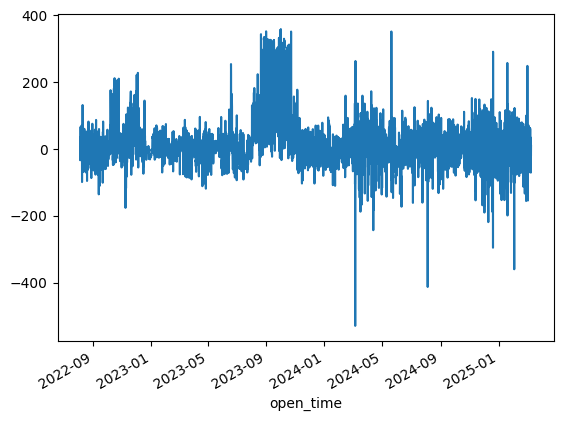

In [93]:
(eth_price - eth_out_sample_predictions).plot()

In [94]:
(eth_price - eth_out_sample_predictions).mean()

15.186795124025581

In [95]:
eth_residuals = eth_price - eth_out_sample_predictions
mean = eth_residuals.mean()
std = eth_residuals.std()

(eth_residuals - mean) / std

open_time
2022-08-05 08:00:00    0.686328
2022-08-05 12:00:00   -0.688077
2022-08-05 16:00:00    0.187545
2022-08-05 20:00:00    0.291787
2022-08-06 00:00:00   -0.146442
                         ...   
2025-03-09 16:00:00   -1.046260
2025-03-09 20:00:00   -1.209293
2025-03-10 00:00:00    0.264342
2025-03-10 04:00:00   -0.500924
2025-03-10 08:00:00   -0.083961
Length: 5688, dtype: float64

In [96]:
coin_to_z_scores = dict()

for coin, model in coin_to_rfr_model.items():
    signals_out_sample = coin_to_signals[coin].loc[out_sample_start_datetime:]
    out_sample_predictions = model.predict(signals_out_sample)
    out_sample_predictions = pd.Series(out_sample_predictions, index=signals_out_sample.index)
    out_sample_price = px_data[coin].loc[out_sample_start_datetime:]['close'].astype(float)
    
    residuals = out_sample_price - out_sample_predictions
    residuals_mean = residuals.mean()
    residuals_std = residuals.std()
    z_scores = (residuals - residuals_mean) / residuals_std
    
    coin_to_z_scores[coin] = z_scores

# eth_out_sample_predictions.plot()

In [97]:
coin_to_z_scores

{'BTCUSDT': open_time
 2022-08-05 08:00:00   -0.403696
 2022-08-05 12:00:00   -0.441010
 2022-08-05 16:00:00   -0.448631
 2022-08-05 20:00:00   -0.412444
 2022-08-06 00:00:00   -0.426452
                          ...   
 2025-03-09 16:00:00    1.258334
 2025-03-09 20:00:00    1.080545
 2025-03-10 00:00:00    1.205525
 2025-03-10 04:00:00    1.241811
 2025-03-10 08:00:00    1.237679
 Length: 5688, dtype: float64,
 'ETHUSDT': open_time
 2022-08-05 08:00:00    0.686328
 2022-08-05 12:00:00   -0.688077
 2022-08-05 16:00:00    0.187545
 2022-08-05 20:00:00    0.291787
 2022-08-06 00:00:00   -0.146442
                          ...   
 2025-03-09 16:00:00   -1.046260
 2025-03-09 20:00:00   -1.209293
 2025-03-10 00:00:00    0.264342
 2025-03-10 04:00:00   -0.500924
 2025-03-10 08:00:00   -0.083961
 Length: 5688, dtype: float64,
 'ADAUSDT': open_time
 2022-08-05 08:00:00    0.312646
 2022-08-05 12:00:00   -0.100643
 2022-08-05 16:00:00    0.191100
 2022-08-05 20:00:00    0.357658
 2022-08-06 00

In [98]:
coin_to_z_scores_df = pd.DataFrame(coin_to_z_scores)
coin_to_z_scores_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,-0.403696,0.686328,0.312646,-0.057859,NaN,1.328472,0.290560
2022-08-05 12:00:00,-0.441010,-0.688077,-0.100643,-0.361970,NaN,0.841931,-1.115793
2022-08-05 16:00:00,-0.448631,0.187545,0.191100,-0.284398,NaN,1.285449,-0.133132
2022-08-05 20:00:00,-0.412444,0.291787,0.357658,-0.196191,NaN,1.579927,1.372146
2022-08-06 00:00:00,-0.426452,-0.146442,0.239604,-0.238864,NaN,0.940006,0.518906
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,1.258334,-1.046260,-1.550918,-0.246150,1.658769,-1.714744,NaN
2025-03-09 20:00:00,1.080545,-1.209293,-1.459865,-0.561420,1.618037,-1.760994,NaN
2025-03-10 00:00:00,1.205525,0.264342,-0.480251,-0.088348,1.673635,-1.563090,NaN


In [99]:
coin_to_z_scores_df.rank(axis=1)

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,1.0,5.0,4.0,2.0,NaN,6.0,3.0
2022-08-05 12:00:00,3.0,2.0,5.0,4.0,NaN,6.0,1.0
2022-08-05 16:00:00,1.0,4.0,5.0,2.0,NaN,6.0,3.0
2022-08-05 20:00:00,1.0,3.0,4.0,2.0,NaN,6.0,5.0
2022-08-06 00:00:00,1.0,3.0,4.0,2.0,NaN,6.0,5.0
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,5.0,3.0,2.0,4.0,6.0,1.0,NaN
2025-03-09 20:00:00,5.0,3.0,2.0,4.0,6.0,1.0,NaN
2025-03-10 00:00:00,5.0,4.0,2.0,3.0,6.0,1.0,NaN


In [100]:
ranked_z_scores = coin_to_z_scores_df.rank(axis=1)
demeaned_ranked_z_scores = ranked_z_scores.subtract(ranked_z_scores.mean(axis=1), axis=0)
demeaned_ranked_z_scores

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,-2.5,1.5,0.5,-1.5,NaN,2.5,-0.5
2022-08-05 12:00:00,-0.5,-1.5,1.5,0.5,NaN,2.5,-2.5
2022-08-05 16:00:00,-2.5,0.5,1.5,-1.5,NaN,2.5,-0.5
2022-08-05 20:00:00,-2.5,-0.5,0.5,-1.5,NaN,2.5,1.5
2022-08-06 00:00:00,-2.5,-0.5,0.5,-1.5,NaN,2.5,1.5
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,1.5,-0.5,-1.5,0.5,2.5,-2.5,NaN
2025-03-09 20:00:00,1.5,-0.5,-1.5,0.5,2.5,-2.5,NaN
2025-03-10 00:00:00,1.5,0.5,-1.5,-0.5,2.5,-2.5,NaN


In [101]:
port_positions = -1 * demeaned_ranked_z_scores.divide(demeaned_ranked_z_scores.abs().sum(axis=1), axis=0)
port_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,0.277778,-0.166667,-0.055556,0.166667,NaN,-0.277778,0.055556
2022-08-05 12:00:00,0.055556,0.166667,-0.166667,-0.055556,NaN,-0.277778,0.277778
2022-08-05 16:00:00,0.277778,-0.055556,-0.166667,0.166667,NaN,-0.277778,0.055556
2022-08-05 20:00:00,0.277778,0.055556,-0.055556,0.166667,NaN,-0.277778,-0.166667
2022-08-06 00:00:00,0.277778,0.055556,-0.055556,0.166667,NaN,-0.277778,-0.166667
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,-0.166667,0.055556,0.166667,-0.055556,-0.277778,0.277778,NaN
2025-03-09 20:00:00,-0.166667,0.055556,0.166667,-0.055556,-0.277778,0.277778,NaN
2025-03-10 00:00:00,-0.166667,-0.055556,0.166667,0.055556,-0.277778,0.277778,NaN


In [102]:
close_price_df = pd.DataFrame({ticker: px_data[ticker]["close"] for ticker in px_data}).astype(float)
close_price_out_sample_df = close_price_df.loc[out_sample_start_datetime:]
close_price_out_sample_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,23411.10,1714.07,0.51615,318.0515,NaN,8.550,0.933
2022-08-05 12:00:00,23015.46,1672.04,0.50670,313.3216,NaN,8.370,0.902
2022-08-05 16:00:00,22934.66,1680.88,0.50989,314.5281,NaN,8.510,0.903
2022-08-05 20:00:00,23318.34,1738.40,0.51742,315.9000,NaN,8.830,0.927
2022-08-06 00:00:00,23169.82,1733.57,0.51630,315.2363,NaN,8.680,0.936
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,82557.54,2040.16,0.73140,560.9500,2.1632,4.064,NaN
2025-03-09 20:00:00,80672.47,2015.68,0.72080,554.3900,2.1324,4.021,NaN
2025-03-10 00:00:00,81997.61,2056.91,0.74220,560.1700,2.1716,4.205,NaN


In [103]:
close_price_ret = close_price_out_sample_df / close_price_out_sample_df.shift() - 1
close_price_ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-05 12:00:00,-0.016900,-0.024521,-0.018309,-0.014871,NaN,-0.021053,-0.033226
2022-08-05 16:00:00,-0.003511,0.005287,0.006296,0.003851,NaN,0.016726,0.001109
2022-08-05 20:00:00,0.016729,0.034220,0.014768,0.004362,NaN,0.037603,0.026578
2022-08-06 00:00:00,-0.006369,-0.002778,-0.002165,-0.002101,NaN,-0.016988,0.009709
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,-0.006561,-0.026005,-0.032156,-0.010199,-0.010204,-0.019305,NaN
2025-03-09 20:00:00,-0.022833,-0.011999,-0.014493,-0.011694,-0.014238,-0.010581,NaN
2025-03-10 00:00:00,0.016426,0.020455,0.029689,0.010426,0.018383,0.045760,NaN


In [104]:
weighted_positions = port_positions.shift() * close_price_ret
weighted_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-05 12:00:00,-0.004694,0.004087,0.001017,-0.002479,NaN,0.005848,-0.001846
2022-08-05 16:00:00,-0.000195,0.000881,-0.001049,-0.000214,NaN,-0.004646,0.000308
2022-08-05 20:00:00,0.004647,-0.001901,-0.002461,0.000727,NaN,-0.010445,0.001477
2022-08-06 00:00:00,-0.001769,-0.000154,0.000120,-0.000350,NaN,0.004719,-0.001618
...,...,...,...,...,...,...,...
2025-03-09 16:00:00,0.001094,0.001445,-0.005359,-0.000567,0.002834,-0.005363,NaN
2025-03-09 20:00:00,0.003806,-0.000667,-0.002415,0.000650,0.003955,-0.002939,NaN
2025-03-10 00:00:00,-0.002738,0.001136,0.004948,-0.000579,-0.005106,0.012711,NaN


In [105]:
gross_return = weighted_positions.sum(axis=1)
gross_return

open_time
2022-08-05 08:00:00    0.000000
2022-08-05 12:00:00    0.001933
2022-08-05 16:00:00   -0.004915
2022-08-05 20:00:00   -0.007957
2022-08-06 00:00:00    0.000947
                         ...   
2025-03-09 16:00:00   -0.005916
2025-03-09 20:00:00    0.002389
2025-03-10 00:00:00    0.010372
2025-03-10 04:00:00   -0.003137
2025-03-10 08:00:00    0.001117
Length: 5688, dtype: float64

<Axes: xlabel='open_time'>

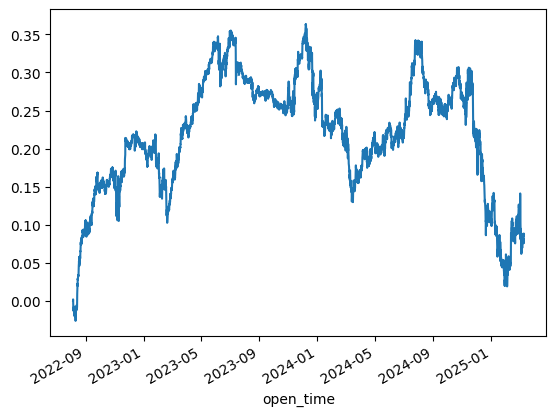

In [106]:
gross_return.cumsum().plot()

In [107]:
to = (port_positions.fillna(0) - port_positions.shift().fillna(0)).abs().sum(1)
to

open_time
2022-08-05 08:00:00    1.000000
2022-08-05 12:00:00    1.111111
2022-08-05 16:00:00    0.888889
2022-08-05 20:00:00    0.444444
2022-08-06 00:00:00    0.000000
                         ...   
2025-03-09 16:00:00    0.222222
2025-03-09 20:00:00    0.000000
2025-03-10 00:00:00    0.222222
2025-03-10 04:00:00    0.222222
2025-03-10 08:00:00    0.000000
Length: 5688, dtype: float64

In [108]:
tcost_bps = 20 # (commissions + slip)
net_ret = gross_return.subtract(to*tcost_bps*1e-4,fill_value=0)
net_ret

open_time
2022-08-05 08:00:00   -0.002000
2022-08-05 12:00:00   -0.000289
2022-08-05 16:00:00   -0.006693
2022-08-05 20:00:00   -0.008846
2022-08-06 00:00:00    0.000947
                         ...   
2025-03-09 16:00:00   -0.006360
2025-03-09 20:00:00    0.002389
2025-03-10 00:00:00    0.009928
2025-03-10 04:00:00   -0.003581
2025-03-10 08:00:00    0.001117
Length: 5688, dtype: float64

Net return - small set of coins, max_depth = 5, include data from 3 periods ago

<Axes: xlabel='open_time'>

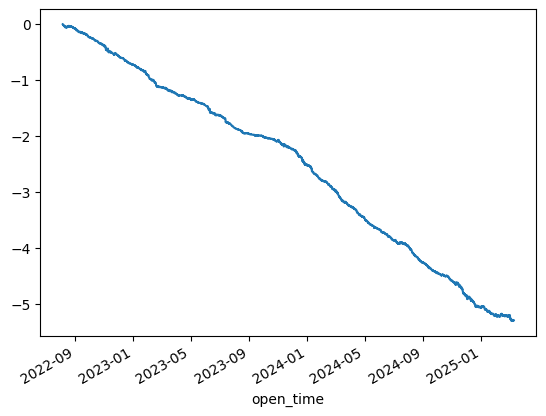

In [109]:
net_ret.cumsum().plot()

In [110]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-10.862042731050774

Net return - small set of coins, max_depth = 5

<Axes: xlabel='open_time'>

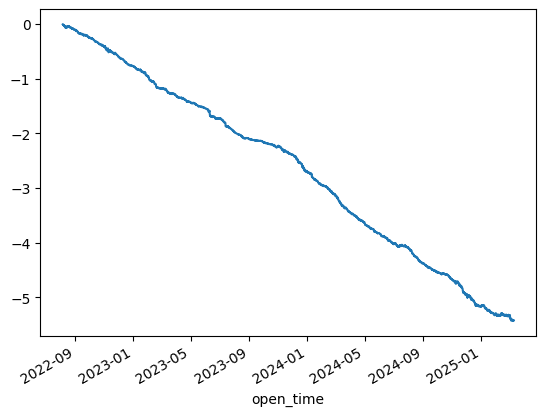

In [72]:
net_ret.cumsum().plot()

In [73]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-11.082618987237904

Net return - small set of coins, max_depth = 10

<Axes: xlabel='open_time'>

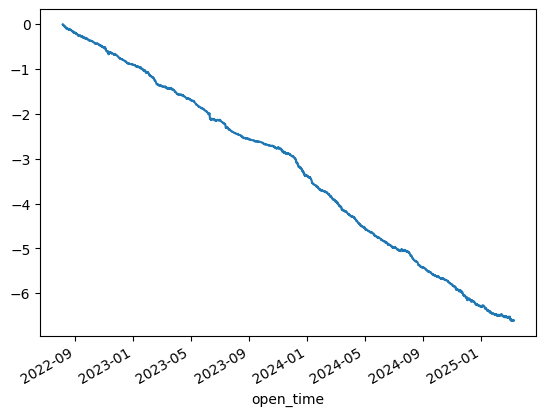

In [50]:
net_ret.cumsum().plot()

In [51]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.336161028926432

Net return - small set of coins, no limits on regressor parameters.

<Axes: xlabel='open_time'>

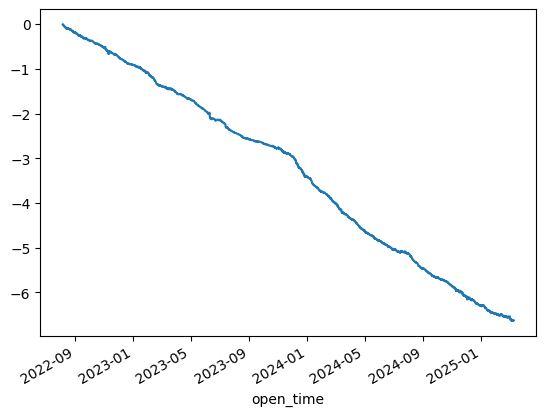

In [28]:
net_ret.cumsum().plot()

In [29]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.327196085694583